In [53]:
import numpy as np
import matplotlib.pyplot as plt
import galsim as gs
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [76]:
# To hide

def plot_psf(psf_img, cmap='viridis'):
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(121)
    im = ax.imshow(psf_img, interpolation='none', origin='lower', cmap=cmap)
    ax.set_xlabel('x [pixels]')
    ax.set_ylabel('y [pixels]')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title('PSF')


    ax = fig.add_subplot(122)
    im = ax.imshow(np.log(abs(psf_img)), interpolation='none', origin='lower', cmap=cmap)
    ax.set_xlabel('x [pixels]')
    ax.set_ylabel('y [pixels]')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title('log(PSF)')

    plt.show()
    

# Sources of the PSF

In this section we give the definition of the PSF and go through the different contributors of the PSF.


## Definition

We can vaguely define the Point Spread Function as the response of imaging system to a point source. The concept of PSF is used throughout many imaging applications, some of them are astronomical imaging and medical imaging. Depending on the science application the definition and its sources may vary. However, they all include the [diffraction](https://en.wikipedia.org/wiki/Diffraction) phenomena. The fact of having a non-infinite lens sets a limit on the resolution of the imaging system.

We will focus on PSFs for astronomical imaging and analyze its main sources.




### Examples of PSFs



- __Airy PSF__ 

If we dispose of an optical system with an aberration-free lens with a circular aperture, the resulting PSF would be the Airy disk [ref](https://en.wikipedia.org/wiki/Airy_disk). Its only contributor would be the diffraction phenomena.


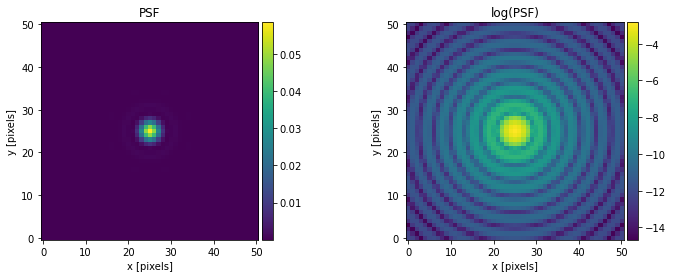

In [69]:
 
lam = 700    # nm
diam = 1.0    # meters
image_size = 51 # pixels
pixel_scale = 0.04  # arcsec / pixel

airy = gs.Airy(lam=lam, diam=diam, scale_unit=gs.arcsec)
airy_psf = gs.ImageF(image_size, image_size)
_ = airy.drawImage(image=airy_psf, scale=pixel_scale)

plot_psf(airy_psf.array)

- __Ground-based PSF__

The PSFs observed with a ground-based optical system generally include the effects of the atmosphere. It can be seen as a varying low-pass filter so the PSFs will look more like blobs where the finer details were averaged by the atmosphere. We use a Moffat profile to model this type of PSF [ref](https://en.wikipedia.org/wiki/Moffat_distribution) for a long-exposure of a ground-based detector.


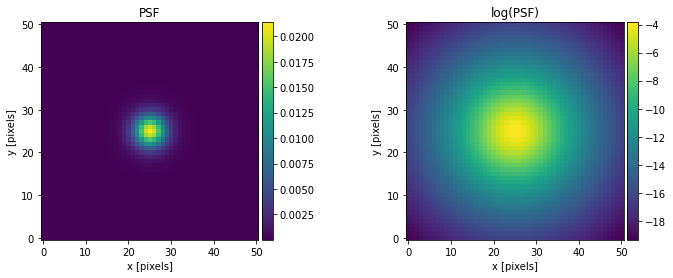

In [73]:

psf_beta = 5.       # dimensionless parameter
psf_re = 1.0       # arcsec
pixel_scale = 0.3  # arcsec / pixel

moffat = gs.Moffat(beta=psf_beta, half_light_radius=psf_re)
moffat_psf = gs.ImageF(image_size, image_size)
_ = moffat.drawImage(image=moffat_psf, scale=pixel_scale)

plot_psf(moffat_psf.array)


- __Space-based PSF__

The PSF observed by a space telescope is not affected by the atmosphere. That is one of the main motivations of space surveys. This is why they will be closer to the diffraction limit. The main contribution of these PSFs are the aberrations of the optical system. 


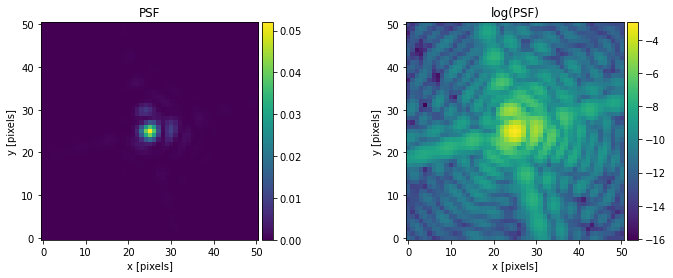

In [80]:
psf_D = 2.4            # meters
psf_lam = 700.0        # nanometers; note that OpticalPSF will automatically convert units to
                       # get lam/diam in units of arcsec, unless told otherwise.  In this case,
                       # that is (900e-9m / 2.4m) * 206265 arcsec/rad = 0.077 arcsec.
psf_obsc = 0.125       # (0.3m / 2.4m) = 0.125
psf_nstruts = 4
psf_strut_thick = 0.07
psf_strut_angle = 15 * gs.degrees

psf_defocus = 0.04     # The aberrations are all taken to be quite modest here.
psf_astig1 = 0.03      #
psf_astig2 = -0.01
psf_coma1 = 0.02
psf_coma2 = 0.04
psf_trefoil1 = -0.02
psf_trefoil2 = 0.04

pixel_scale = 0.02

optical = gs.OpticalPSF(
                lam=psf_lam, diam=psf_D, obscuration=psf_obsc,
                nstruts=psf_nstruts, strut_thick=psf_strut_thick, strut_angle=psf_strut_angle,
                defocus=psf_defocus, astig1=psf_astig1, astig2=psf_astig2,
                coma1=psf_coma1, coma2=psf_coma2, trefoil1=psf_trefoil1, trefoil2=psf_trefoil2)
    

optical_psf = gs.ImageF(image_size, image_size)
_ = optical.drawImage(image=optical_psf, scale=pixel_scale)

plot_psf(optical_psf.array)


## Contributors to the PSF


### Optic level

- __Mirrors__
    - _Aberrations_
        - Mirrors are not perfectly spheric and include some aberrations that introduce optical path differences for the incoming light rays. 
    - _Size_
        - The size of the main mirror has a direct implicance to the size of the PSF. Following the diffraction theory, the larger the mirror for the lens, the smaller size the PSF should have.
    - _Polishing effects_
        - The polishing of the mirrors aims to have a perfectly smooth surface. However, the manufacturing process is not perfect and small errors remain in the surface of the mirrors. They are sometimes referred to as _surface errors_. For example, the surface errors estimated for the Hubble Space Telescope can be seen in Figure 2 in {cite}`krist2011` and are in the range of +/- 30nm.


- __Optical system__
    - _Misalignment_
        - Misalignement of optical elements can cause a defocus of the system.  For example, in Figure 7 and 8 from {cite}`jee2011` one can see the effects of Charge-Coupled Devices (CCD) misalignements on the focal plane on a simulation of the LSST mission {cite}`LSST2009`.
    - Scattered light
        - It consist of spuriours reflections within the optical system and the detector. An example for the HST mission see Figure 3 from {cite}`krist1995c`.
    - _Wavelength dependency_
        - The optical system is composed by several elements where some of them can be non-ideal refractive elements. This means that they introdcuce a wavelength dependance variation.
    - _Obscurations_
        - Depending on the optical system design it might require arms to sustain the camera. These obscurations modify the shape of the PSF and vary depending on the source's angle of incidence. They are 3D structures that are projected on the 2D pupil plane. For example, the projected obscurations of the Hubble Space Telescope can be seen in Figure 1 from {cite}`krist2011`.



- __Filters__
    - Passband
        - The filters serve to limit the the wavelengths incoming to the detector. Ideally they would be a perfect band-pass filter, begin one at the desired wavelength range and zero on the other wavelengths. However, it is not possible to manufacture an ideal filter. A real one does not have an abrupt transition, meaning that there are out-of-band contributions. It is also non-flat, meanining that the passband is near the unity but it changes with the wavelength. See this [page](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/docs/filt.html) to visualise some examples of filters.


### Ground-based

- __Atmosphere__
    - The atmosphere plays a central role in ground-based observations. The refractive index of the atmosphere varies rapidly with the position generating different optical paths for the incoming light. As a consequence, the way it affects the PSF changes if we consider short-term exposures or long-term exposures. It also depends of the incoming wavelength. See {cite}`jee2011` for a first study on the LSST mission.


### Space-based

- __Guiding errors__
    - The satellite should remain perfectly still during an exposure. This is not the case and there exist a pointing error making the exposure the integration of the varyign satellite pointing. It sometimes referred as _Jitter_ or _Attitude and Orbit Control System_.
- __Thermal variations__
    - The satellite experiences time where the sun is closer or were it is eclipsed by other object. This can occasionate high temperature changes in the space telescope. These temperature variations dilate and contract the optical system making it change of state as a function of temperature. It is sometimes to as _telescope's breathing_ for its repetitive pattern due to the orbits. See {cite}`nino2007` for an HST study of temperature variations.
- __Polarisation__
    - Starlight can be naturally polarised by galactic foreground dust. The different polarisations that the incoming light has can interact differently with chromatic elements of the optical system. This occasionates variations that are polarisation dependent. 

### Detector level


- __Undersampling__
    - Many detectors, specially space-based ones, are undersampled or not Nyquist sampled. Generally, several exposures of the same object with small shifts are taken in order to super-resolve the object. See Section 3.5 and Figure 4 from {cite}`krist2011` for an analysis over the HST telescope.
- __Charge Difussion Effect__
    - There is a charge diffusion of the electrons between the pixels. It depends on the depth of the substrate and on the wavelength. See {cite}`krist2003` for a study of the HST mission.
- __Charge Transfer Inefficiency__
    - This phenomenon describes the inefficiency of transfering the charge when reading CCD detectors. It can be caused by charged particle radiation damage in space-based detectors. See {cite}`rhodes2010` and {cite}`massey2009`for studies of this phenomenon.
- __Brighter Fatter Effect__
    - Each CCD in an camera is not independent of each other. One charge starts accumulating it modifies boundary pixel's electric fields. This occasionates a variation of the PSF size as a function of the flux and the wavelength. See {cite}`guyonnet2015` for a study and a model of the effect.
- __Quantum efficiency__
    - This effect describes the ratio of created electrons from the number of incoming photons. It depends on the wavelength and on the detector's technology.
    
- __Other effects__
  - Analog-to-Digital Unit non-linearity
  - Thermal noise
  - Background estimation and subtraction
 